now only fish/engine

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Paths
data_folder = "./time_sets_standardized"

# Function to load and process individual vessel data
def load_and_process_vessel_data(folder_path):
    data, labels = [], []
    status_counts = {}

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))

            if "Heading" not in df.columns or df["Heading"].isnull().any():
                continue  # Skip files with missing or invalid data

            # Extract the time series features
            sog = df["SOG"].values
            cog = df["COG"].values
            heading = df["Heading"].values

            # Subtract the initial COG
            initial_cog = cog[0]
            cog = cog - initial_cog
            heading = heading - initial_cog

            # Normalize angles to the range [0, 360) after subtraction
            cog = np.mod(cog, 360)
            heading = np.mod(heading, 360)

            # Cyclical encoding for COG and Heading
            cog_sin = np.sin(np.radians(cog))
            cog_cos = np.cos(np.radians(cog))
            heading_sin = np.sin(np.radians(heading))
            heading_cos = np.cos(np.radians(heading))

            # Calculate aggregated features
            sog_mean, sog_min, sog_max, sog_std = np.mean(sog), np.min(sog), np.max(sog), np.std(sog)
            cog_mean, cog_min, cog_max, cog_std = np.mean(cog), np.min(cog), np.max(cog), np.std(cog)
            heading_mean, heading_min, heading_max, heading_std = (
                np.mean(heading),
                np.min(heading),
                np.max(heading),
                np.std(heading),
            )
            sog_slope = np.polyfit(range(len(sog)), sog, 1)[0]  # SOG slope
            cog_slope = np.polyfit(range(len(cog)), cog, 1)[0]  # COG slope

            # Flatten the time series data
            flattened_features = np.concatenate([
                sog,  # Raw SOG values
                cog_sin, cog_cos,  # Cyclical encoding for COG
                heading_sin, heading_cos  # Cyclical encoding for Heading
            ])

            # Combine aggregated and flattened features
            combined_features = np.concatenate([
                [
                    sog_mean, sog_min, sog_max, sog_std, sog_slope,
                    cog_mean, cog_min, cog_max, cog_std, cog_slope,
                    heading_mean, heading_min, heading_max, heading_std
                ],
                flattened_features
            ])

            # Extract label
            label = df["Navigational status"].iloc[0]
            if label in ["Under way using engine", "Engaged in fishing"]:
                data.append(combined_features)
                labels.append(label)

                if label not in status_counts:
                    status_counts[label] = 0
                status_counts[label] += 1

    return np.array(data), np.array(labels), status_counts

# Load and preprocess data
data, labels, status_counts = load_and_process_vessel_data(data_folder)

# Encode labels (e.g., "Under way using engine" -> 0, "Engaged in fishing" -> 1)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Print class distribution
print("Class distribution:", dict(zip(label_encoder.classes_, np.bincount(labels))))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Apply undersampling to balance the classes
def undersample_data(X, y):
    class_0 = X[y == 0]  # Minority class (0)
    class_1 = X[y == 1]  # Majority class (1)
    
    class_1_undersampled = resample(class_1, replace=False, n_samples=len(class_0), random_state=42)
    
    X_balanced = np.vstack((class_0, class_1_undersampled))
    y_balanced = np.hstack((np.zeros(len(class_0)), np.ones(len(class_1_undersampled))))
    
    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = undersample_data(X_train, y_train)

# Standardize the data (normalizing it to have zero mean and unit variance)
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)  # Fit and transform on training data
X_test = scaler.transform(X_test)  # Only transform test data

# Reshape the data to 3D format for CNN input: (samples, timesteps, features)
X_train_balanced = X_train_balanced.reshape((X_train_balanced.shape[0], X_train_balanced.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build a more regularized 1D CNN model
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train_balanced.shape[1], 1), kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_balanced, y_train_balanced, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


Class distribution: {'Engaged in fishing': 4429, 'Under way using engine': 7944}
Epoch 1/100
220/220 [==============================] - 5s 7ms/step - loss: 0.7726 - accuracy: 0.7497 - val_loss: 0.5397 - val_accuracy: 0.7669
Epoch 2/100
220/220 [==============================] - 1s 5ms/step - loss: 0.5519 - accuracy: 0.7617 - val_loss: 0.5144 - val_accuracy: 0.7580
Epoch 3/100
220/220 [==============================] - 1s 5ms/step - loss: 0.5289 - accuracy: 0.7696 - val_loss: 0.4945 - val_accuracy: 0.7737
Epoch 4/100
220/220 [==============================] - 1s 4ms/step - loss: 0.5180 - accuracy: 0.7718 - val_loss: 0.5035 - val_accuracy: 0.7737
Epoch 5/100
220/220 [==============================] - 1s 5ms/step - loss: 0.5140 - accuracy: 0.7722 - val_loss: 0.4922 - val_accuracy: 0.7741
Epoch 6/100
220/220 [==============================] - 1s 5ms/step - loss: 0.5082 - accuracy: 0.7733 - val_loss: 0.5149 - val_accuracy: 0.7552
Epoch 7/100
220/220 [==============================] - 1s 5ms

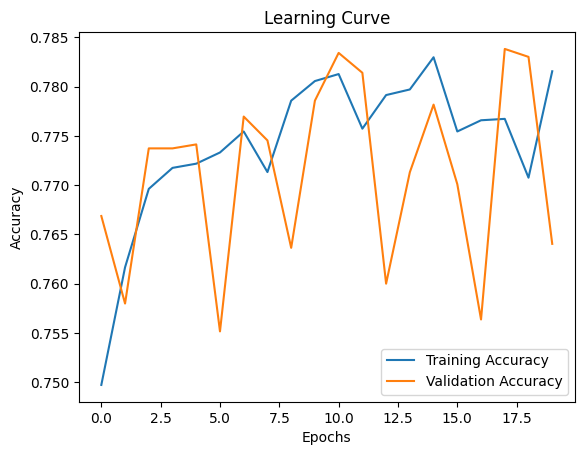

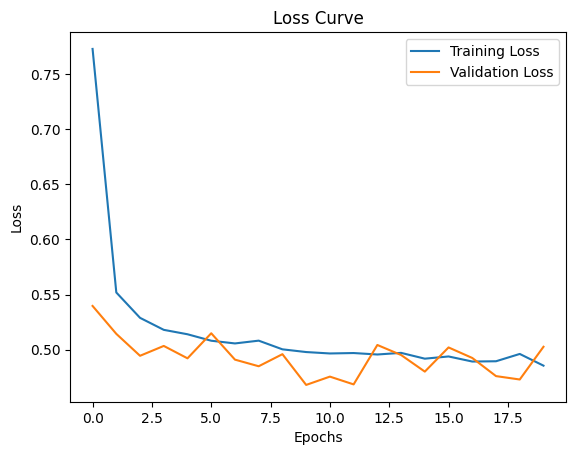

78/78 [==============================] - 0s 3ms/step


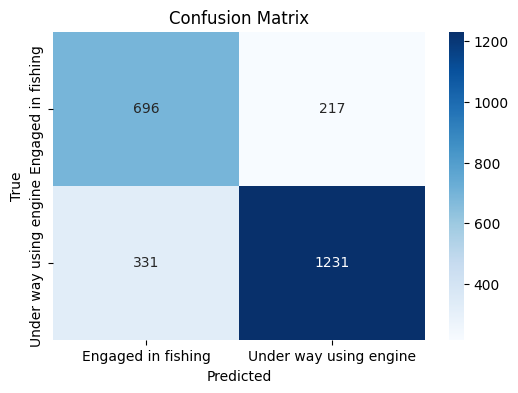

                        precision    recall  f1-score   support

    Engaged in fishing       0.68      0.76      0.72       913
Under way using engine       0.85      0.79      0.82      1562

              accuracy                           0.78      2475
             macro avg       0.76      0.78      0.77      2475
          weighted avg       0.79      0.78      0.78      2475

78/78 [==============================] - 0s 2ms/step


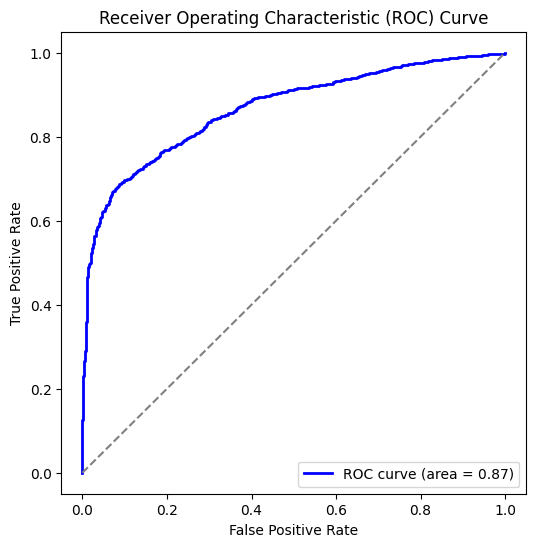

Accuracy: 0.7786
Precision (Class 0): 0.6777
Precision (Class 1): 0.8501
Recall (Class 0): 0.7623
Recall (Class 1): 0.7881
F1-Score (Class 0): 0.7175
F1-Score (Class 1): 0.8179

Classification Report:
                         precision    recall  f1-score   support

    Engaged in fishing       0.68      0.76      0.72       913
Under way using engine       0.85      0.79      0.82      1562

              accuracy                           0.78      2475
             macro avg       0.76      0.78      0.77      2475
          weighted avg       0.79      0.78      0.78      2475


AUC: 0.8677


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

# Train the model (previously fitted)
# history = model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot the learning curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Precision, Recall, F1-Score
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print(report)

# ROC Curve and AUC
y_pred_prob = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])  # Only for positive class (class 1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Calculate and display accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average=None)
recall = recall_score(y_test, y_pred_classes, average=None)
f1 = f1_score(y_test, y_pred_classes, average=None)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (Class 0): {precision[0]:.4f}')
print(f'Precision (Class 1): {precision[1]:.4f}')
print(f'Recall (Class 0): {recall[0]:.4f}')
print(f'Recall (Class 1): {recall[1]:.4f}')
print(f'F1-Score (Class 0): {f1[0]:.4f}')
print(f'F1-Score (Class 1): {f1[1]:.4f}')
print("\nClassification Report:\n", report)
print(f'\nAUC: {roc_auc:.4f}')
